<a href="https://colab.research.google.com/github/duypham01/PDENet/blob/main/Stefan_InverseII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SETUP
import random
import numpy as np
import csv
import tensorflow as tf
import tensorflow.keras as keras
import itertools
import math
import time
import tensorflow_probability as tfp
import functools

pi = math.pi

In [ ]:
# GENERATING DATA (AND WRITE TO .CSV)
def flatArr(x):
    y = []
    for row in x:
        for el in row:
            y.append(el)
    return np.array(y).flatten()

def sampling(x_range, y_range, int_size, bound_size):
    int_x = np.random.uniform(x_range[0], x_range[1], int_size)
    int_y = np.random.uniform(y_range[0], y_range[1], int_size)
    Boundary_points = []
    for i in range(bound_size):
        random_point = [random.uniform(x_range[0], x_range[1]), random.uniform(y_range[0], y_range[1])]
        random_index = random.randint(0,1)
        if random_index == 0:
            random_value = random.choice([x_range[0], x_range[1]])
        else:
            random_value = random.choice([y_range[0], y_range[1]])
        random_point[random_index] = random_value
        Boundary_points.append(random_point)
    bound_x = np.array(Boundary_points)[:, 0]
    bound_y = np.array(Boundary_points)[:, 1]

    return int_x, int_y, bound_x, bound_y

# training data
N_train = 1000;        # number of points
x, t, _, _ = sampling([0.0, 1.0], [0.0, 1.0], N_train, N_train)

# write training data to .csv file
# with open('/content/drive/MyDrive/Papers/Code (chung)/data_train.csv', mode='w') as f:
with open('data_train.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(N_train):
        csv_writer.writerow([x[i], t[i], t[i]])


# test data
N_test = 200;        # number of points
int_x, int_y, bound_x, bound_y = sampling([0.0, 1.0], [0.0, 1.0], N_test, N_test)

# write test data to .csv file
# with open('/content/drive/MyDrive/Papers/Code (chung)/data_test.csv', mode='w') as f:
with open('data_test.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(N_test):
        csv_writer.writerow([int_x[i], int_y[i]])

def exact_s(t):
    return 2-math.sqrt(3-2*t)

def exact_u(x,t):
    return -x**2/2+2*x-1/2-t

def generateTruePoint(m):
    t = []
    x = []
    u = []
    for i in range(m):
        t.append(np.float32(np.random.uniform(0.0, 1.0, 1))[0])
        x.append(np.float32(np.random.uniform(0.0, exact_s(t[i]), 1))[0])
        u.append(exact_u(x[i],t[i]))
    return x, t, u

M = 100
x_data, t_data, u_data = generateTruePoint(M)
with open('data_train_true.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(M):
        csv_writer.writerow([x_data[i], t_data[i], u_data[i]])

In [ ]:
# READ DATA

# load the dataset
# data_train = np.float32(np.loadtxt('/content/drive/MyDrive/Papers/Code (chung)/data_train.csv', delimiter=','))
# data_test = np.float32(np.loadtxt('/content/drive/MyDrive/Papers/Code (chung)/data_test.csv', delimiter=','))

data_train = np.float32(np.loadtxt('data_train.csv', delimiter=','))
data_train_true = np.float32(np.loadtxt('data_train_true.csv', delimiter=','))
data_test = np.float32(np.loadtxt('data_test.csv', delimiter=','))

In [ ]:
# BUILD NETWORK

# dimension of input and output
in_dim = 2
out_dim = 1

# number of neurons on each layer
nn = [16, 16, 16, 16]

# input layer
inputs = keras.Input(shape=(in_dim,), name='points')

# hidden layers
hidden = keras.layers.Dense(nn[0], activation='tanh', name='hidden_1')(inputs)
for i in range(len(nn)-1):
    hidden = keras.layers.Dense(nn[i+1], activation='tanh', name='hidden_' + str(i+2))(hidden)

# output layer
outputs = keras.layers.Dense(out_dim, activation='linear', name="u")(hidden)

# create network
PDEmodel_u = keras.Model(inputs=inputs, outputs=outputs, name='u')
inputs_s = keras.Input(shape=(1,), name='points')
hidden_s = keras.layers.Dense(nn[0], activation='tanh', name='hiddenS_1')(inputs_s)
for i in range(len(nn)-1):
    hidden_s = keras.layers.Dense(nn[i+1], activation='tanh', name='hiddenS_' + str(i+2))(hidden_s)

# output layer
outputs_s = keras.layers.Dense(out_dim, activation='linear', name="s")(hidden_s)
PDEmodel_s = keras.Model(inputs=inputs_s, outputs=outputs_s, name='s')

# show network details
PDEmodel_u.summary()
PDEmodel_s.summary()

Model: "u"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 points (InputLayer)         [(None, 2)]               0         
                                                                 
 hidden_1 (Dense)            (None, 16)                48        
                                                                 
 hidden_2 (Dense)            (None, 16)                272       
                                                                 
 hidden_3 (Dense)            (None, 16)                272       
                                                                 
 hidden_4 (Dense)            (None, 16)                272       
                                                                 
 u (Dense)                   (None, 1)                 17        
                                                                 
Total params: 881
Trainable params: 881
Non-trainable params: 0
_

In [ ]:
# TRAINING

# GRAD U
def grad_u(X):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        u = PDEmodel_u(X)
        u = u[:, 0]

    u_x = tape.gradient(u, X)[:, 0]
    u_t = tape.gradient(u, X)[:, 1]

    return u, u_x, u_t

# return 1D weights
def get_weights(PDEmodel):
    w = []
    for layer in PDEmodel.layers[1:]:
        weights_biases = layer.get_weights()
        weights = weights_biases[0].flatten()
        biases = weights_biases[1]
        w.extend(weights)
        w.extend(biases)
    return w

def merge_w(w1,w2):
    w=[]
    for g in w1:
        w.append(g)
    size_u = len(w)
    for g in w2:
        w.append(g)
    return w, size_u

# get size of weights in each model's layer
sizes_w = []
sizes_b = []
for layer in PDEmodel_u.layers[1:]:
    weights_biases = layer.get_weights()
    sizes_w.append(weights_biases[0].flatten().size)
    sizes_b.append(weights_biases[1].size)

# convert 1D weights to multi dimension weights in each model's layer
def set_weights(w):
    for i, layer in enumerate(PDEmodel_u.layers[1:]):
        start_weights = sum(sizes_w[:i]) + sum(sizes_b[:i])
        end_weights = sum(sizes_w[:i+1]) + sum(sizes_b[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_w[i] / sizes_b[i])
        weights = tf.reshape(weights, [w_div, sizes_b[i]])
        biases = w[end_weights:end_weights + sizes_b[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)

# --------------------------------------

sizes_wS = []
sizes_bS = []
for layer in PDEmodel_s.layers[1:]:
    weights_biases = layer.get_weights()
    sizes_wS.append(weights_biases[0].flatten().size)
    sizes_bS.append(weights_biases[1].size)

# convert 1D weights to multi dimension weights in each model's layer
def set_weights_S(w):
    for i, layer in enumerate(PDEmodel_s.layers[1:]):
        start_weights = sum(sizes_wS[:i]) + sum(sizes_bS[:i])
        end_weights = sum(sizes_wS[:i+1]) + sum(sizes_bS[:i])
        weights = w[start_weights:end_weights]
        w_div = int(sizes_wS[i] / sizes_bS[i])
        weights = tf.reshape(weights, [w_div, sizes_bS[i]])
        biases = w[end_weights:end_weights + sizes_bS[i]]
        weights_biases = [weights, biases]
        layer.set_weights(weights_biases)

def convert_input(i1, i2):
    size = i1.shape.as_list()[0]
    i1 = tf.reshape(i1,[size,1])
    i2 = tf.reshape(i2,[size,1])
    return tf.concat([i1,i2], 1)

losses_hist = []
def train(epochs, BATCH_SIZE=50, SHUFFLE_BUFFER_SIZE=100, optimizer = 'adam'):
    # split into datasets
    P_r = data_train[:,0:2]
    P_s = data_train[:,2]
    P_data = data_train_true[:,0:2]
    P_u = data_train_true[:,2]

    # CHOOSE OPTIMIZER
    if (optimizer == 'adam'):
        optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999)
        P_r = tf.convert_to_tensor(P_r, dtype=tf.float32)
        P_s = tf.convert_to_tensor(P_s, dtype=tf.float32)
        P_data = tf.convert_to_tensor(P_data, dtype=tf.float32)
        P_u = tf.convert_to_tensor(P_u, dtype=tf.float32)
        # for loop epochs
        for epoch in range(epochs):
            start_epoch = time.time()
            with tf.GradientTape() as tape:
                with tf.GradientTape(persistent=True) as tape1:
                    tape1.watch(P_r)
                    u, u_x, u_t = grad_u(P_r)

                # u_xx and u_yy
                u_xx = tape1.gradient(u_x, P_r)[:,0]

                # loss_in
                R = u_t - u_xx
                loss_r = tf.reduce_mean(tf.math.square(R))

                # loss_s
                s = PDEmodel_s(P_s)[:,0]
                input_ut = convert_input(s,P_s)
                us, us_x, _ = grad_u(input_ut)
                loss_sbc = tf.reduce_mean(tf.math.square(us))
                loss_snc = tf.reduce_mean(tf.math.square(us_x-tf.math.sqrt(3-2*P_s[:])))
            
                #loss_s
                s0 = PDEmodel_s(tf.convert_to_tensor([0.0], dtype=tf.float32))[:,0]
                loss_s0 = tf.math.square(s0-2.0+tf.math.sqrt(3.0))

                #loss data
                u_data = PDEmodel_u(P_data)[:,0]
                loss_u_data = tf.reduce_mean(tf.math.square(u_data-P_u[:]))

                # total_loss
                loss = loss_r + loss_u_data + loss_sbc + loss_snc + loss_s0
                print("[%4s] loss = %12.8f \t %4.3fs" % (epoch, loss, time.time() - start_epoch))
                losses_hist.append(loss.numpy())
            
            # update paremeters
            grads, grads_s = tape.gradient(loss, [PDEmodel_u.weights, PDEmodel_s.weights])
            optimizer.apply_gradients(zip(grads, PDEmodel_u.weights))
            optimizer.apply_gradients(zip(grads_s, PDEmodel_s.weights))
            
            

    if (optimizer == 'l-bfgs'):
        P_r = tf.convert_to_tensor(P_r, dtype=tf.float32)
        P_ux0 = tf.convert_to_tensor(P_ux0, dtype=tf.float32)
        P_ut0 = tf.convert_to_tensor(P_ut0, dtype=tf.float32)
        P_s = tf.convert_to_tensor(P_s, dtype=tf.float32)
        w, size_Model_u = merge_w(get_weights(PDEmodel_u),get_weights(PDEmodel_s))
        def function_factory(P_r, P_ux0, P_ut0, P_s):

            def loss_grad(weights):
                start_epoch = time.time()
                with tf.GradientTape() as tape:
                    with tf.GradientTape(persistent=True) as tape1:
                        set_weights(weights[:size_Model_u])
                        set_weights_S(weights[size_Model_u:])
                        tape1.watch(P_r)
                        u, u_x, u_t = grad_u(P_r)

                    # u_xx and u_yy
                    u_xx = tape1.gradient(u_x, P_r)[:,0]

                    # loss_in
                    R = u_t - u_xx
                    loss_r = tf.reduce_mean(tf.math.square(R))

                    # loss_ux0
                    ux0 = PDEmodel_u(P_ux0)
                    ux0 = ux0[:,0]
                    loss_ux0 = tf.reduce_mean(tf.math.square(ux0 + P_ux0[:,0]*P_ux0[:,0]/2-2*P_ux0[:,0]+0.5))

                    # loss_ut0
                    _, ut0_x, _ = grad_u(P_ut0)
                    loss_ux0 = tf.reduce_mean(tf.math.square(ut0_x - 2.0))
                    print("done u")
                    # loss_s
                    s = PDEmodel_s(P_s)[:,0]
                    input_ut = convert_input(s,P_s)
                    us, us_x, _ = grad_u(input_ut)
                    loss_sbc = tf.reduce_mean(tf.math.square(us))
                    loss_snc = tf.reduce_mean(tf.math.square(us_x-tf.math.sqrt(3-2*P_s[:])))
                
                    #
                    s0 = PDEmodel_s(tf.convert_to_tensor([0.0], dtype=tf.float32))[:,0]
                    loss_s0 = tf.math.square(s0-2.0+tf.math.sqrt(3.0))
                    # loss_s
                    loss = loss_r + loss_ux0 + loss_sbc + loss_snc + loss_s0
                    print("loss = %12.5f \t %4.3fs" % (loss, time.time() - start_epoch))
                    losses_hist.append(loss.numpy())
                grad, grad_s = tape.gradient(loss, [PDEmodel_u.weights, PDEmodel_s.weights])
                # grad_s = tape.gradient(loss, PDEmodel_s.weights)
                grad_1D = []
                for g in grad:
                    grad_1D.append(tf.reshape(g, [-1]))

                for g in grad_s:
                    grad_1D.append(tf.reshape(g, [-1]))
                grad_1D = tf.concat(grad_1D, 0)
                print(loss)
                print(grad_1D)
                return loss, grad_1D
            return loss_grad
        # update paremeters

        func = function_factory(P_r, P_ux0, P_ut0, P_s)
        
        # add loss_batch to loss
        tfp.optimizer.lbfgs_minimize(func,
            tf.convert_to_tensor(w, dtype=tf.float32),
            max_iterations=epochs)
        # set_weights(result)
        # print(result)

        # start = get_weights()
        # @tf.function
        # def opt_with_bfgs():
        #     return tfp.optimizer.lbfgs_minimize(
        #         loss_grad,
        #         initial_position=tf.convert_to_tensor(start, dtype=tf.float32),
        #         max_iterations=epochs)

        # results = run(opt_with_bfgs)
        # print('BFGS Results')
        # print('Converged:', results.converged)
        # print('Location of the minimum:', results.position)
        # print('Number of iterations:', results.num_iterations)
    

    

[   0] loss =   0.00107655 	 0.034s
[   1] loss =   0.00174517 	 0.035s
[   2] loss =   0.02089696 	 0.037s
[   3] loss =   0.00154213 	 0.036s
[   4] loss =   0.01051397 	 0.034s
[   5] loss =   0.01333701 	 0.035s
[   6] loss =   0.00379693 	 0.043s
[   7] loss =   0.00189280 	 0.033s
[   8] loss =   0.00836406 	 0.035s
[   9] loss =   0.00832196 	 0.041s
[  10] loss =   0.00262266 	 0.037s
[  11] loss =   0.00161449 	 0.040s
[  12] loss =   0.00567921 	 0.047s
[  13] loss =   0.00605263 	 0.034s
[  14] loss =   0.00227219 	 0.035s
[  15] loss =   0.00128779 	 0.044s
[  16] loss =   0.00401847 	 0.034s
[  17] loss =   0.00447362 	 0.035s
[  18] loss =   0.00188162 	 0.047s
[  19] loss =   0.00119713 	 0.035s
[  20] loss =   0.00311090 	 0.041s
[  21] loss =   0.00331068 	 0.040s
[  22] loss =   0.00146124 	 0.034s
[  23] loss =   0.00121982 	 0.035s
[  24] loss =   0.00258750 	 0.040s
[  25] loss =   0.00240829 	 0.035s
[  26] loss =   0.00112821 	 0.036s
[  27] loss =   0.00134011 	

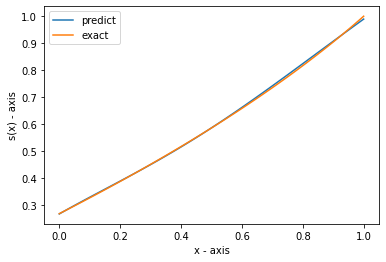

L2_u =  0.004445626245291304


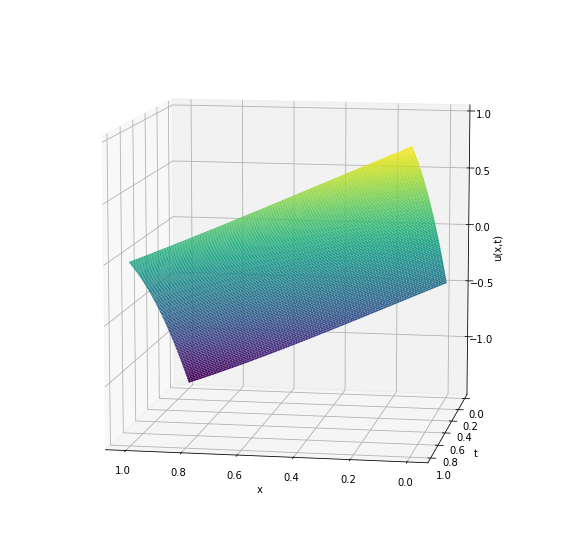

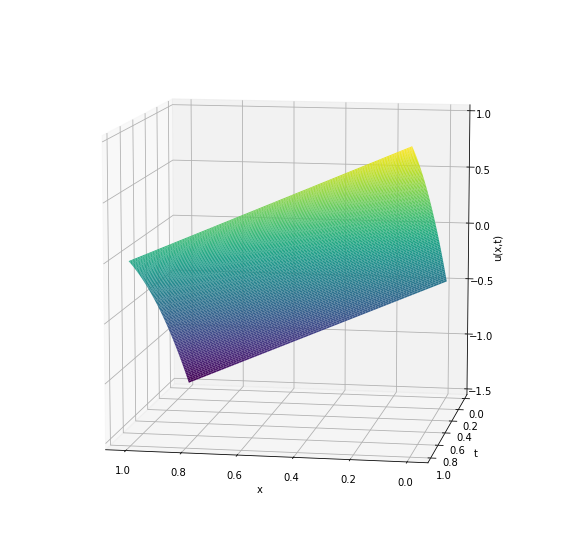

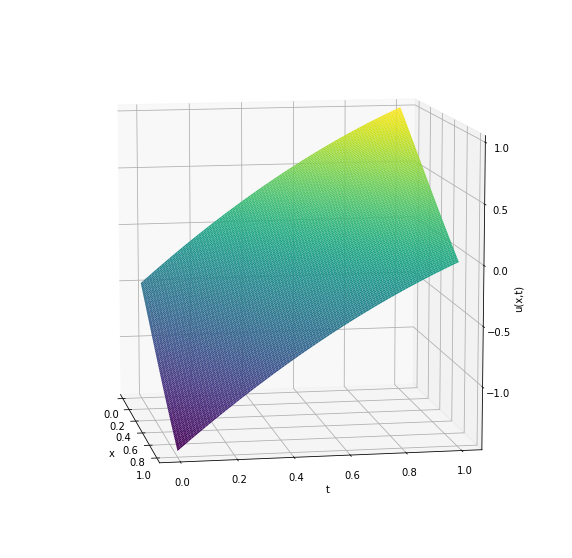

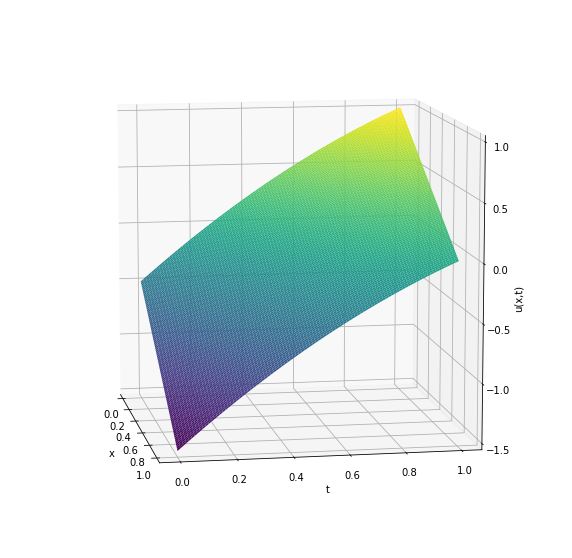

In [ ]:
train(1000, optimizer='adam')
def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    elif n == 1:
        return([start])
    else:
        return([])
P_s = np.array(seq(0.0,1.0,0.01))
P_tf=tf.convert_to_tensor(P_s, dtype=tf.float32)
lambda_pred=PDEmodel_s(P_tf)[:,0].numpy()
def exact_sol(t):
    return 2-np.sqrt(3-2*t)

lambda_ex = exact_sol(P_s)

mse = ((lambda_pred - lambda_ex)**2).mean(axis=None)

L2_lambda = math.sqrt(mse)
print("L2_lambda = ", L2_lambda)

# u_pred = PDEmodel_u(P_tf)[:,0].numpy()
# U_ex = data_train[:,2]

# mse = ((u_pred - U_ex)**2).mean(axis=None)

# L2_u = math.sqrt(mse)
# print("L2_u = ", L2_u)



import matplotlib.pyplot as plt
 
# line 1 points
x1 = P_s
y1 = lambda_pred
# plotting the line 1 points
plt.plot(x1, y1, label = "predict")
 
# line 2 points
x2 = P_s
y2 = lambda_ex
# plotting the line 2 points
plt.plot(x2, y2, label = "exact")
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('s(x) - axis')
# giving a title to my graph
# plt.title('s(x) approximate')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

def sampling1(t,x,h_x,h_t):
    X = np.array(seq(x[0],x[1],h_x))
    T = np.array(seq(t[0],t[1],h_t))
    XX=[]
    TT=[]
    for i in X:
        for j in T:
            XX.append(i)
            TT.append(j)
    return TT, XX

TT, XX = sampling1([0.0, 1.0], [0.0, 1.0], 0.01, 0.01)
P = np.column_stack([XX, TT])
P_tf=tf.convert_to_tensor(P, dtype=tf.float32)
u_pred=PDEmodel_u(P_tf)[:,0].numpy()
def exact_sol(x,t):
    return -x**2/2+2*x-0.5-t
u_ex = exact_sol(P[:,0],P[:,1])

mse = ((u_pred - u_ex)**2).mean(axis=None)

L2_u = math.sqrt(mse)
print("L2_u = ", L2_u)

import matplotlib.pyplot as plt
x=1
t=1
delta_x = 0.01
delta_t = 0.01
N_x = int(x/delta_x)
N_t = int(t/delta_t)
x_arr = np.array(seq(0,x,delta_x))
t_arr = np.array(seq(0,t,delta_t))
B = np.zeros((N_x+1, N_t+1))
B_ex = np.zeros((N_x+1, N_t+1))
# P = []
# for i in range(N_x+1):
#     for j in range(N_t+1):
#         P.append([x_arr[j], t_arr[i]])

# P = tf.convert_to_tensor(P, dtype=tf.float32)
# U = PDEmodel(P)
k=0
def sol_s(t):
    return 2-np.sqrt(3-2*t)
for i in range(N_x+1):
    for j in range(N_t+1):
        # p = tf.reshape(tf.convert_to_tensor([x_arr[j], t_arr[i]], dtype=tf.float32), [1,2])
        # U = PDEmodel(p)[0]
        B[i][j]=u_pred[k]
        B_ex[i][j]=u_ex[k]
        # if (x_arr[i]>sol_s(t_arr[j])):
        #     B[i][j]=np.nan
        #     B_ex[i][j]=np.nan
        k = k+1

X, T = np.meshgrid(x_arr, t_arr)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, B , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=100)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
plt.show()

X, T = np.meshgrid(x_arr, t_arr)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, B_ex , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=100)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
plt.show()


X, T = np.meshgrid(x_arr, t_arr)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, B , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=-10)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
plt.show()

X, T = np.meshgrid(x_arr, t_arr)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, B_ex , rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')   #surface 1
# ax.plot_surface(KY, KZ, -E+1, rstride=1, cstride=1, cmap=cm.viridis, vmin=-2, vmax=2)  #surface 2
ax.view_init(elev=10, azim=-10)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
plt.show()

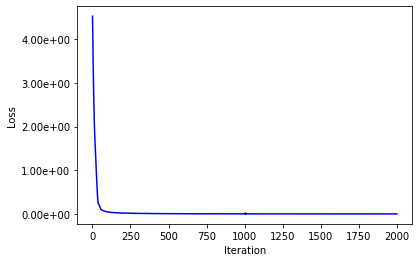

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
losses = np.array(losses_hist)
losses = losses.reshape(len(losses))
epochs = losses.size
x_epochs = [i+1 for i in range(epochs)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_epochs,losses, color = 'blue')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.setp(ax, xlabel='Iteration')
plt.setp(ax, ylabel='Loss')
plt.show()

In [ ]:
loss_file = open("Loss.txt", "w")
for row in np.array(losses_hist).reshape(len(losses_hist), 1):
    np.savetxt(loss_file, row)
loss_file.close()